In [11]:
# 1. Importando as bilbiotecas de interesse
from fenics import *
import numpy as np
import os
import shutil
import time
import matplotlib.pyplot as plt

# 1.1. Importando as propriedades
# from propriedades_5CAC import *
g = Constant(9.81)
w_c = Constant(300.0)
w_0 = Constant(100.0)

def rho_s(T):
    rho_val = 2500
    return rho_val


def C_p(T):
    C_p_val = 900
    return C_p_val


def lmbda(P_v, T):
    lmbda_val = 1.265
    return lmbda_val


# Antoine pressure
def P_s(T):
    C_1 = -5800.2206
    C_2 = 1.3914993
    C_3 = -4.8640239e-2
    C_4 = 4.1764768e-5
    C_5 = -1.4452093e-8
    C_6 = 6.5459673
    Pvps_vals = exp(C_1 / T + C_2 + C_3 * T + C_4 * T**2 + C_5 * T**3 +
                    C_6 * ln(T))
    return Pvps_vals


def w_d(T):
    A1 = 13; A2 = 33.5; A3 = 20; K1 = 20; K2 = 7; K3 = 5; L1 = 205; L2 = 310; L3 = 500;
    K4 = 1; L4 = 540; LA = 0.02; LB = 0
    x = T-273.15
    val  = A1*(1-exp(-(x/L1)**K1))
    val += A2*(1-exp(-(x/L2)**K2))
    val += A3*(1-exp(-(x/L3)**K3))
    val += (LA*x + LB) * (exp(-(x/L4)**K4))
    return (val + abs(val))/2


def dw_ddt(T, T_n):
    delta = 1e-8
    dT = delta * T_n
    dw_ddT = ((w_d(T_n + dT / 2) - w_d( T_n - dT / 2)) / (dT))
    dTdt = (T - T_n) / dt
    return dw_ddT * dTdt

# Relative humidity
def h(P_v, T):
    return P_v / P_s(T)

def m(T):
    return 1.04 - ((T - 263.15)**2) / ((T - 263.15)**2 +
                                       22.34 * (298.15 - 263.15)**2)

def w_1(P_v, T):
    return w_c * ((w_0 / w_c) * (h(P_v, T)))**(1 / m(T))

def w_2(P_v, T):
    return w_c * (0.037 * (h(P_v, T) - 1.04) +
                                          (w_0/w_c) * (1.0 - ((T - 273.15)**2.0) / (3.6e5)))

def w(P_v, T):
        w_096 = w_1(0.96 * P_s(T), T)
        w_104 = w_2(1.04 * P_s(T), T)
        w_int = w_096 + ((w_104 - w_096) * (h(P_v, T) - 0.96) / 0.08)
        return conditional(le(T, 647.15),
                       conditional(le(h(P_v, T), 0.96), w_1(P_v, T),
                                   conditional(le(h(P_v, T), 1.04), w_int,
                                               w_2(P_v, T))), 0.0)

def dwdt(P_v, T, P_v_n, T_n):
    delta = 1e-4
    dP = delta * P_v_n
    dT = delta * T_n
    dwdP = ((w(P_v_n + dP / 2, T_n) - w(P_v_n - dP / 2, T_n)) / (dP))
    dwdT = ((w(P_v_n, T_n + dT / 2) - w(P_v_n, T_n - dT / 2)) / (dT))
    dPdt = (P_v - P_v_n) / dt
    dTdt = (T - T_n) / dt
    return dwdP * dPdt + dwdT * dTdt


def C_a(T):
    return conditional(le(T, 647.3), 3.5e5 * ((647.3 - T)**(1 / 3)), 0.0)


C_w = Constant(4100.0)
def C_p_l(T):
    return C_w

a_0 = Constant(1.0839648370802355e-10)

def a(P, T):
    return a_0

# from utils import *
def criar_pasta(case_name):
    '''
    Função para criar um diretório para armezanar os resultados de uma
    simulação.

    Parametros
    ----------
    case_name: str
        Nome do caso a ser simulado.

    Returna
    -------
    dir_saida: str
        Endereço do diretório de saída.

    dir_local: str
        Endereço do diretório local da onde se roda a simulação.


    Notas:
    ---
    Nenhum.

    '''
    dir_saida = f'./resultados/{case_name}'
    dir_local = os.getcwd()
    if not os.path.exists(dir_saida):
        os.mkdir(dir_saida)
    return dir_saida, dir_local

# os.mkdir(f'./resultados')

print(f'| Bibliotecas importadas com sucesso!')
print('----------------------------------------')

# 2. Definição do nome do caso
case_name = 'real_case_01'
print(f'| Rodando o caso: "{case_name}"...')

# 3. Criação da pasta de resultados do caso
dir_saida, dir_local = criar_pasta(case_name)
print('|--- Pasta criada com sucesso!')

# 4. Criação dos backups
# # 4.1. Backup da Simulação
# shutil.copy(dir_local + '/Fake Simulation.ipynb',
#             dir_saida + '/backup_' + case_name + '.ipynb')
# 4.2. Backup das Propriedades
# shutil.copy(dir_local + '/propriedades_5CAC.py',
#             dir_saida + '/backup_propriedades.py')
# print('|--- Back-up criado com sucesso!')

# # 5. Criação da malha
# def criar_malha():
#     '''

#     '''

#     lx = 1
#     ly = 3
#     nx = 10
#     ny = 30
#     malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)

#     flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
#     flags.set_all(0)

#     class top(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[1], ly, 1e-2)


#     class bottom(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[1], 0, 1e-2)


#     class left(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[0], 0, 1e-2)


#     class right(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[0], lx, 1e-2)

#     top = top()
#     bottom = bottom()
#     left = left()
#     right = right()

#     top.mark(flags, 1)
#     bottom.mark(flags, 2)
#     left.mark(flags, 3)
#     right.mark(flags, 4)

#     print('|--- Malha criada com sucesso!')
#     return malha, flags

# malha, flags = criar_malha()

# 5. Criação da malha
def criar_malha():
    lx = 130 / 1000 # comprimento (no sentido dos sensores)
    ly = 114 / 1000 # largura
    lz = 100 / 1000 # altura
    nx = int(lx * 1000)
    ny = int(ly * 1000)
    nz = int(lz * 1000)
    # malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)
    malha = IntervalMesh(nx, 0, lx)


    flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
    flags.set_all(0)

    class hotface(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, 1e-2)

    class coldface(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], lx, 1e-2)

    # class top(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[1], ly, 1e-2)

    # class bottom(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[1], 0, 1e-2)

    # class left(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[0], 0, 1e-2)

    # class right(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[0], lx, 1e-2)

    hotface = hotface()
    coldface = coldface()
    # top = top()
    # bottom = bottom()
    # left = left()
    # right = right()

    hotface.mark(flags, 1)
    coldface.mark(flags, 2)
    # top.mark(flags, 3)
    # bottom.mark(flags, 4)
    # left.mark(flags, 5)
    # right.mark(flags, 6)

    print('|--- Malha criada com sucesso!')
    return malha, flags

malha, flags = criar_malha()

# 6. Criação dos espaços de funções mistas
# Mixed element and space functions definition
P1 = FiniteElement('P', malha.ufl_cell(), 1)
element = MixedElement([P1, P1])
V = FunctionSpace(malha, element)
v_1, v_2 = TestFunctions(V)
u = Function(V)
P_v, T = split(u)
u_n = Function(V)
P_v_n, T_n = split(u_n)

ds = Measure("ds", domain=malha, subdomain_data=flags)

print('|--- Espaço de Funcões criado com sucesso!')

# 7. Definição das condições iniciais
t = 0
dt = 5  # passo de tempo [s]
t_rampa = 20 * 60
t_patamar = 10 * 60

T_0 = 20 + 273.15  # Temperatura de inicio do domínio [°C]
T_n = interpolate(Constant(T_0), V.sub(1).collapse())
P_0 = Constant(2850.0)
P_v_inf = P_0
h_m = Constant(1e-6)
# RH_0 = 0.90 
# P_0 = RH_0 * P_s(T_0)
P_v_n = interpolate(P_0, V.sub(0).collapse())


# 8. Definição das condições de contorno
BC_array = np.load('./Dir_BC_HF_EX001.npz')
t_DC = BC_array['t']
T_2_DC = BC_array['T_2']
def curva_de_aq(t):
    T_D_val = np.interp(t / 60, t_DC, T_2_DC) + 273.15

    return T_D_val

T_D = Expression('T_D_t', degree=2, T_D_t=curva_de_aq(t))

cond_dirich = []
def aplicar_Dirichlet(T_D, flag):
    cond_dirich.append(DirichletBC(V.sub(1), T_D, flags, 1))

    print('|--- Condição de Contorno de Dirichlet aplicada com sucesso!')

aplicar_Dirichlet(T_D, flags)
# Vai aparecer diretamente no problema matemático
# def aplicar_Neumann(q_N, flag):
#     print('|--- Condição de Contorno de Neumann aplicada com sucesso!')

T_M = 23 + 273.15 # Temperatura do ambiente em [°C]
h_T = 10 # Coeficiente de película em [W/m2 K]

# 9. Definir o problema matemático
def criar_problema():
    # 9.1. Definição do Resíduo
    # Mass balance equation
    ResP = dwdt(P_v, T, P_v_n, T_n) * v_1 * dx
    ResP += (a(P_v_n, T_n) / g) * inner(nabla_grad(P_v), nabla_grad(v_1)) * dx
    ResP += - dw_ddt(T, T_n) * v_1 * dx

    # Energy balance equation
    ResT = rho_s(T_n) * C_p(T_n) * ((T - T_n) / dt) * v_2 * dx
    ResT += lmbda(P_v_n, T) * inner(nabla_grad(T), nabla_grad(v_2)) * dx
    # ResT += + (h_d) * dw_ddt(T, T_n) * v_2 * dx
    ResT += - C_a(T_n) * dwdt(P_v, T, P_v_n, T_n) * v_2 * dx
    ResT += C_p_l(T_n) * (a(P_v_n, T_n) / g) * \
        inner(nabla_grad(P_v_n), nabla_grad(T_n)) * v_2 * dx
                
    
    # 9.2. Condições de Contorno de Neumann
    ResP += h_m * (P_v - P_v_inf) * v_1 * (ds(1) + ds(2))
    ResT += (h_T * (T - T_M)) * v_2 * (ds(2))

    Res = ResP + ResT
    Jac = derivative(Res, u)
    problema = NonlinearVariationalProblem(Res, u,
                                      cond_dirich, Jac)
    print('|--- Problema criado com sucesso!')
    return problema

problema = criar_problema()

# 10. Definir o solver para resolver o problema matemático
def criar_solver(problema):
    non_lin_solver = NonlinearVariationalSolver(problema)
    prm = non_lin_solver.parameters
    prm["newton_solver"]["absolute_tolerance"] = 1E-6
    prm["newton_solver"]["relative_tolerance"] = 1E-13
    prm["newton_solver"]["maximum_iterations"] = 10
    prm['newton_solver']['error_on_nonconvergence'] = True

    # Set FEniCS log level
    set_log_level(50)
    print('|--- Solver criado com sucesso!')
    return non_lin_solver

solver = criar_solver(problema)

# 11. Definir Funções para salvar os dados

# Files for saving the fields
filex = XDMFFile(dir_saida + '/Fields.xdmf')
filex.parameters['functions_share_mesh'] = True
filex.parameters['rewrite_function_mesh'] = False
filex.parameters["flush_output"] = True

T_RAM = []
P_v_RAM = []
def escrever_na_RAM(P_v, T):
    T_RAM.append(T.copy(deepcopy=True))
    P_v_RAM.append(P_v.copy(deepcopy=True))
                    
    print('Dados armazenados na RAM com sucesso!')

def escrever_no_disco(P_v, T, t):
    filex.write(T, t)
    filex.write(P_v, t)
    print('Dados salvos com sucesso!')

# 12. Loop temporal
t_f = 5 * 3600  # tempo final da simulação [s]
# Opção 1 - Usando loop com for
# nt = int(t_f / dt)
# for i in range(nt):
#     t = t + dt


# Opção 2 - Usando loop com while
print('|--- Começando o loop com sucesso(?)')

while t <= t_f:
    print(f'|------ t = {t} s   | {t / (t_f) * 100:.4} % Completo')
    T_D.T_D_t = curva_de_aq(t)
    print(f'|------ T_D = {T_D.T_D_t:.4} °C')
    solver.solve()
    P_v, T = u.split(True)
    T_n.vector()[:] = T.vector()
    P_v_n.vector()[:] = P_v.vector()
                    
    escrever_no_disco(P_v, T, t)
    escrever_na_RAM(P_v, T)
    t = t + dt

T_RAM_nodes = np.array([T_i.vector()[:] for T_i in T_RAM])
P_v_RAM_nodes = np.array([P_v_i.vector()[:] for P_v_i in P_v_RAM])
                    
np.savez(dir_saida + '/valores_nodais_T', T_nodes=T_RAM_nodes)
np.savez(dir_saida + '/valores_nodais_P_v', P_v_nodes=P_v_RAM_nodes)
                    
print('Simulação terminada com sucesso!')


| Bibliotecas importadas com sucesso!
----------------------------------------
| Rodando o caso: "real_case_01"...
|--- Pasta criada com sucesso!
|--- Malha criada com sucesso!
|--- Espaço de Funcões criado com sucesso!
|--- Condição de Contorno de Dirichlet aplicada com sucesso!
|--- Problema criado com sucesso!
|--- Solver criado com sucesso!
|--- Começando o loop com sucesso(?)
|------ t = 0 s   | 0.0 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5 s   | 0.02778 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10 s   | 0.05556 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15 s   | 0.08333 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 20 s   | 0.1111 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM c

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 395 s   | 2.194 % Completo
|------ T_D = 391.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 400 s   | 2.222 % Completo
|------ T_D = 393.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 405 s   | 2.25 % Completo
|------ T_D = 395.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 410 s   | 2.278 % Completo
|------ T_D = 396.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 415 s   | 2.306 % Completo
|------ T_D = 398.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 420 s   | 2.333 % Completo
|------ T_D = 400.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 425 s   | 2.361 % Completo
|------ T_D = 401.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 430 s   | 2.389 % Completo
|------ T_D = 40

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 995 s   | 5.528 % Completo
|------ T_D = 503.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1000 s   | 5.556 % Completo
|------ T_D = 504.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1005 s   | 5.583 % Completo
|------ T_D = 504.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1010 s   | 5.611 % Completo
|------ T_D = 505.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1015 s   | 5.639 % Completo
|------ T_D = 505.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1020 s   | 5.667 % Completo
|------ T_D = 506.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1025 s   | 5.694 % Completo
|------ T_D = 507.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1030 s   | 5.722 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1915 s   | 10.64 % Completo
|------ T_D = 579.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1920 s   | 10.67 % Completo
|------ T_D = 580.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1925 s   | 10.69 % Completo
|------ T_D = 580.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1930 s   | 10.72 % Completo
|------ T_D = 580.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1935 s   | 10.75 % Completo
|------ T_D = 580.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1940 s   | 10.78 % Completo
|------ T_D = 581.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1945 s   | 10.81 % Completo
|------ T_D = 581.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1950 s   | 10.83 % Completo
|------

Dados armazenados na RAM com sucesso!
|------ t = 2265 s   | 12.58 % Completo
|------ T_D = 601.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2270 s   | 12.61 % Completo
|------ T_D = 601.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2275 s   | 12.64 % Completo
|------ T_D = 601.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2280 s   | 12.67 % Completo
|------ T_D = 602.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2285 s   | 12.69 % Completo
|------ T_D = 602.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2290 s   | 12.72 % Completo
|------ T_D = 602.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2295 s   | 12.75 % Completo
|------ T_D = 602.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2300 s   | 12.78 % Completo
|------ T_D = 603.2 °C
Dados salv

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2735 s   | 15.19 % Completo
|------ T_D = 625.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2740 s   | 15.22 % Completo
|------ T_D = 625.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2745 s   | 15.25 % Completo
|------ T_D = 625.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2750 s   | 15.28 % Completo
|------ T_D = 626.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2755 s   | 15.31 % Completo
|------ T_D = 626.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2760 s   | 15.33 % Completo
|------ T_D = 626.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2765 s   | 15.36 % Completo
|------ T_D = 626.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 2770 s   | 15.39 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3160 s   | 17.56 % Completo
|------ T_D = 642.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3165 s   | 17.58 % Completo
|------ T_D = 643.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3170 s   | 17.61 % Completo
|------ T_D = 643.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3175 s   | 17.64 % Completo
|------ T_D = 643.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3180 s   | 17.67 % Completo
|------ T_D = 643.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3185 s   | 17.69 % Completo
|------ T_D = 643.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3190 s   | 17.72 % Completo
|------ T_D = 644.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3195 s   | 17.75 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3570 s   | 19.83 % Completo
|------ T_D = 656.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3575 s   | 19.86 % Completo
|------ T_D = 656.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3580 s   | 19.89 % Completo
|------ T_D = 657.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3585 s   | 19.92 % Completo
|------ T_D = 657.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3590 s   | 19.94 % Completo
|------ T_D = 657.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3595 s   | 19.97 % Completo
|------ T_D = 657.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3600 s   | 20.0 % Completo
|------ T_D = 657.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3605 s   | 20.03 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3980 s   | 22.11 % Completo
|------ T_D = 668.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3985 s   | 22.14 % Completo
|------ T_D = 668.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3990 s   | 22.17 % Completo
|------ T_D = 668.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 3995 s   | 22.19 % Completo
|------ T_D = 668.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4000 s   | 22.22 % Completo
|------ T_D = 668.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4005 s   | 22.25 % Completo
|------ T_D = 669.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4010 s   | 22.28 % Completo
|------ T_D = 669.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4015 s   | 22.31 % Completo
|------

Dados armazenados na RAM com sucesso!
|------ t = 4325 s   | 24.03 % Completo
|------ T_D = 676.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4330 s   | 24.06 % Completo
|------ T_D = 677.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4335 s   | 24.08 % Completo
|------ T_D = 677.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4340 s   | 24.11 % Completo
|------ T_D = 677.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4345 s   | 24.14 % Completo
|------ T_D = 677.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4350 s   | 24.17 % Completo
|------ T_D = 677.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4355 s   | 24.19 % Completo
|------ T_D = 677.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4360 s   | 24.22 % Completo
|------ T_D = 677.7 °C
Dados salv

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4755 s   | 26.42 % Completo
|------ T_D = 686.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4760 s   | 26.44 % Completo
|------ T_D = 686.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4765 s   | 26.47 % Completo
|------ T_D = 686.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4770 s   | 26.5 % Completo
|------ T_D = 686.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4775 s   | 26.53 % Completo
|------ T_D = 686.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4780 s   | 26.56 % Completo
|------ T_D = 686.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4785 s   | 26.58 % Completo
|------ T_D = 686.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 4790 s   | 26.61 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5220 s   | 29.0 % Completo
|------ T_D = 695.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5225 s   | 29.03 % Completo
|------ T_D = 695.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5230 s   | 29.06 % Completo
|------ T_D = 695.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5235 s   | 29.08 % Completo
|------ T_D = 695.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5240 s   | 29.11 % Completo
|------ T_D = 695.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5245 s   | 29.14 % Completo
|------ T_D = 695.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5250 s   | 29.17 % Completo
|------ T_D = 695.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5255 s   | 29.19 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5680 s   | 31.56 % Completo
|------ T_D = 702.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5685 s   | 31.58 % Completo
|------ T_D = 702.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5690 s   | 31.61 % Completo
|------ T_D = 702.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5695 s   | 31.64 % Completo
|------ T_D = 702.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5700 s   | 31.67 % Completo
|------ T_D = 702.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5705 s   | 31.69 % Completo
|------ T_D = 702.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5710 s   | 31.72 % Completo
|------ T_D = 702.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5715 s   | 31.75 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6130 s   | 34.06 % Completo
|------ T_D = 708.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6135 s   | 34.08 % Completo
|------ T_D = 708.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6140 s   | 34.11 % Completo
|------ T_D = 708.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6145 s   | 34.14 % Completo
|------ T_D = 708.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6150 s   | 34.17 % Completo
|------ T_D = 709.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6155 s   | 34.19 % Completo
|------ T_D = 709.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6160 s   | 34.22 % Completo
|------ T_D = 709.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6165 s   | 34.25 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6595 s   | 36.64 % Completo
|------ T_D = 714.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6600 s   | 36.67 % Completo
|------ T_D = 714.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6605 s   | 36.69 % Completo
|------ T_D = 714.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6610 s   | 36.72 % Completo
|------ T_D = 714.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6615 s   | 36.75 % Completo
|------ T_D = 714.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6620 s   | 36.78 % Completo
|------ T_D = 714.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6625 s   | 36.81 % Completo
|------ T_D = 714.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 6630 s   | 36.83 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7050 s   | 39.17 % Completo
|------ T_D = 719.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7055 s   | 39.19 % Completo
|------ T_D = 719.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7060 s   | 39.22 % Completo
|------ T_D = 719.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7065 s   | 39.25 % Completo
|------ T_D = 719.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7070 s   | 39.28 % Completo
|------ T_D = 719.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7075 s   | 39.31 % Completo
|------ T_D = 719.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7080 s   | 39.33 % Completo
|------ T_D = 719.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7085 s   | 39.36 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7485 s   | 41.58 % Completo
|------ T_D = 723.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7490 s   | 41.61 % Completo
|------ T_D = 723.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7495 s   | 41.64 % Completo
|------ T_D = 723.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7500 s   | 41.67 % Completo
|------ T_D = 723.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7505 s   | 41.69 % Completo
|------ T_D = 723.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7510 s   | 41.72 % Completo
|------ T_D = 723.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7515 s   | 41.75 % Completo
|------ T_D = 723.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7520 s   | 41.78 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7915 s   | 43.97 % Completo
|------ T_D = 727.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7920 s   | 44.0 % Completo
|------ T_D = 727.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7925 s   | 44.03 % Completo
|------ T_D = 727.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7930 s   | 44.06 % Completo
|------ T_D = 727.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7935 s   | 44.08 % Completo
|------ T_D = 727.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7940 s   | 44.11 % Completo
|------ T_D = 727.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7945 s   | 44.14 % Completo
|------ T_D = 727.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 7950 s   | 44.17 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8285 s   | 46.03 % Completo
|------ T_D = 730.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8290 s   | 46.06 % Completo
|------ T_D = 730.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8295 s   | 46.08 % Completo
|------ T_D = 730.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8300 s   | 46.11 % Completo
|------ T_D = 730.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8305 s   | 46.14 % Completo
|------ T_D = 730.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8310 s   | 46.17 % Completo
|------ T_D = 730.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8315 s   | 46.19 % Completo
|------ T_D = 730.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8320 s   | 46.22 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8695 s   | 48.31 % Completo
|------ T_D = 733.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8700 s   | 48.33 % Completo
|------ T_D = 733.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8705 s   | 48.36 % Completo
|------ T_D = 733.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8710 s   | 48.39 % Completo
|------ T_D = 733.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8715 s   | 48.42 % Completo
|------ T_D = 733.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8720 s   | 48.44 % Completo
|------ T_D = 733.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8725 s   | 48.47 % Completo
|------ T_D = 733.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 8730 s   | 48.5 % Completo
|------ 

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9095 s   | 50.53 % Completo
|------ T_D = 735.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9100 s   | 50.56 % Completo
|------ T_D = 735.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9105 s   | 50.58 % Completo
|------ T_D = 735.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9110 s   | 50.61 % Completo
|------ T_D = 735.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9115 s   | 50.64 % Completo
|------ T_D = 735.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9120 s   | 50.67 % Completo
|------ T_D = 736.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9125 s   | 50.69 % Completo
|------ T_D = 736.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9130 s   | 50.72 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9470 s   | 52.61 % Completo
|------ T_D = 737.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9475 s   | 52.64 % Completo
|------ T_D = 737.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9480 s   | 52.67 % Completo
|------ T_D = 738.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9485 s   | 52.69 % Completo
|------ T_D = 738.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9490 s   | 52.72 % Completo
|------ T_D = 738.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9495 s   | 52.75 % Completo
|------ T_D = 738.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9500 s   | 52.78 % Completo
|------ T_D = 738.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9505 s   | 52.81 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9855 s   | 54.75 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9860 s   | 54.78 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9865 s   | 54.81 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9870 s   | 54.83 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9875 s   | 54.86 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9880 s   | 54.89 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9885 s   | 54.92 % Completo
|------ T_D = 740.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 9890 s   | 54.94 % Completo
|------

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10210 s   | 56.72 % Completo
|------ T_D = 741.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10215 s   | 56.75 % Completo
|------ T_D = 741.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10220 s   | 56.78 % Completo
|------ T_D = 742.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10225 s   | 56.81 % Completo
|------ T_D = 742.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10230 s   | 56.83 % Completo
|------ T_D = 742.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10235 s   | 56.86 % Completo
|------ T_D = 742.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10240 s   | 56.89 % Completo
|------ T_D = 742.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10245 s   | 56.92 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10570 s   | 58.72 % Completo
|------ T_D = 743.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10575 s   | 58.75 % Completo
|------ T_D = 743.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10580 s   | 58.78 % Completo
|------ T_D = 743.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10585 s   | 58.81 % Completo
|------ T_D = 743.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10590 s   | 58.83 % Completo
|------ T_D = 743.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10595 s   | 58.86 % Completo
|------ T_D = 743.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10600 s   | 58.89 % Completo
|------ T_D = 743.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10605 s   | 58.92 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10915 s   | 60.64 % Completo
|------ T_D = 745.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10920 s   | 60.67 % Completo
|------ T_D = 745.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10925 s   | 60.69 % Completo
|------ T_D = 745.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10930 s   | 60.72 % Completo
|------ T_D = 745.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10935 s   | 60.75 % Completo
|------ T_D = 745.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10940 s   | 60.78 % Completo
|------ T_D = 745.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10945 s   | 60.81 % Completo
|------ T_D = 745.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10950 s   | 60.83 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11280 s   | 62.67 % Completo
|------ T_D = 746.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11285 s   | 62.69 % Completo
|------ T_D = 746.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11290 s   | 62.72 % Completo
|------ T_D = 746.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11295 s   | 62.75 % Completo
|------ T_D = 746.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11300 s   | 62.78 % Completo
|------ T_D = 746.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11305 s   | 62.81 % Completo
|------ T_D = 746.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11310 s   | 62.83 % Completo
|------ T_D = 746.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11315 s   | 62.86 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11625 s   | 64.58 % Completo
|------ T_D = 747.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11630 s   | 64.61 % Completo
|------ T_D = 747.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11635 s   | 64.64 % Completo
|------ T_D = 747.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11640 s   | 64.67 % Completo
|------ T_D = 747.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11645 s   | 64.69 % Completo
|------ T_D = 747.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11650 s   | 64.72 % Completo
|------ T_D = 747.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11655 s   | 64.75 % Completo
|------ T_D = 747.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11660 s   | 64.78 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11980 s   | 66.56 % Completo
|------ T_D = 748.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11985 s   | 66.58 % Completo
|------ T_D = 748.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11990 s   | 66.61 % Completo
|------ T_D = 748.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 11995 s   | 66.64 % Completo
|------ T_D = 748.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12000 s   | 66.67 % Completo
|------ T_D = 749.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12005 s   | 66.69 % Completo
|------ T_D = 749.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12010 s   | 66.72 % Completo
|------ T_D = 749.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12015 s   | 66.75 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12320 s   | 68.44 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12325 s   | 68.47 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12330 s   | 68.5 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12335 s   | 68.53 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12340 s   | 68.56 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12345 s   | 68.58 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12350 s   | 68.61 % Completo
|------ T_D = 750.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12355 s   | 68.64 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12670 s   | 70.39 % Completo
|------ T_D = 751.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12675 s   | 70.42 % Completo
|------ T_D = 751.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12680 s   | 70.44 % Completo
|------ T_D = 751.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12685 s   | 70.47 % Completo
|------ T_D = 751.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12690 s   | 70.5 % Completo
|------ T_D = 751.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12695 s   | 70.53 % Completo
|------ T_D = 751.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12700 s   | 70.56 % Completo
|------ T_D = 751.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 12705 s   | 70.58 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13040 s   | 72.44 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13045 s   | 72.47 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13050 s   | 72.5 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13055 s   | 72.53 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13060 s   | 72.56 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13065 s   | 72.58 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13070 s   | 72.61 % Completo
|------ T_D = 752.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13075 s   | 72.64 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13390 s   | 74.39 % Completo
|------ T_D = 752.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13395 s   | 74.42 % Completo
|------ T_D = 752.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13400 s   | 74.44 % Completo
|------ T_D = 752.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13405 s   | 74.47 % Completo
|------ T_D = 752.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13410 s   | 74.5 % Completo
|------ T_D = 752.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13415 s   | 74.53 % Completo
|------ T_D = 753.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13420 s   | 74.56 % Completo
|------ T_D = 753.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13425 s   | 74.58 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13720 s   | 76.22 % Completo
|------ T_D = 753.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13725 s   | 76.25 % Completo
|------ T_D = 753.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13730 s   | 76.28 % Completo
|------ T_D = 753.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13735 s   | 76.31 % Completo
|------ T_D = 753.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13740 s   | 76.33 % Completo
|------ T_D = 753.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13745 s   | 76.36 % Completo
|------ T_D = 753.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13750 s   | 76.39 % Completo
|------ T_D = 753.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 13755 s   | 76.42 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14045 s   | 78.03 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14050 s   | 78.06 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14055 s   | 78.08 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14060 s   | 78.11 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14065 s   | 78.14 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14070 s   | 78.17 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14075 s   | 78.19 % Completo
|------ T_D = 754.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14080 s   | 78.22 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14405 s   | 80.03 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14410 s   | 80.06 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14415 s   | 80.08 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14420 s   | 80.11 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14425 s   | 80.14 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14430 s   | 80.17 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14435 s   | 80.19 % Completo
|------ T_D = 755.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14440 s   | 80.22 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14755 s   | 81.97 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14760 s   | 82.0 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14765 s   | 82.03 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14770 s   | 82.06 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14775 s   | 82.08 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14780 s   | 82.11 % Completo
|------ T_D = 755.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14785 s   | 82.14 % Completo
|------ T_D = 755.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 14790 s   | 82.17 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15150 s   | 84.17 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15155 s   | 84.19 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15160 s   | 84.22 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15165 s   | 84.25 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15170 s   | 84.28 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15175 s   | 84.31 % Completo
|------ T_D = 756.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15180 s   | 84.33 % Completo
|------ T_D = 756.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15185 s   | 84.36 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15560 s   | 86.44 % Completo
|------ T_D = 757.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15565 s   | 86.47 % Completo
|------ T_D = 757.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15570 s   | 86.5 % Completo
|------ T_D = 757.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15575 s   | 86.53 % Completo
|------ T_D = 757.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15580 s   | 86.56 % Completo
|------ T_D = 757.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15585 s   | 86.58 % Completo
|------ T_D = 757.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15590 s   | 86.61 % Completo
|------ T_D = 757.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15595 s   | 86.64 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15945 s   | 88.58 % Completo
|------ T_D = 757.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15950 s   | 88.61 % Completo
|------ T_D = 757.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15955 s   | 88.64 % Completo
|------ T_D = 757.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15960 s   | 88.67 % Completo
|------ T_D = 757.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15965 s   | 88.69 % Completo
|------ T_D = 757.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15970 s   | 88.72 % Completo
|------ T_D = 757.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15975 s   | 88.75 % Completo
|------ T_D = 757.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15980 s   | 88.78 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16270 s   | 90.39 % Completo
|------ T_D = 758.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16275 s   | 90.42 % Completo
|------ T_D = 758.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16280 s   | 90.44 % Completo
|------ T_D = 758.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16285 s   | 90.47 % Completo
|------ T_D = 758.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16290 s   | 90.5 % Completo
|------ T_D = 758.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16295 s   | 90.53 % Completo
|------ T_D = 758.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16300 s   | 90.56 % Completo
|------ T_D = 758.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16305 s   | 90.58 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16630 s   | 92.39 % Completo
|------ T_D = 759.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16635 s   | 92.42 % Completo
|------ T_D = 759.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16640 s   | 92.44 % Completo
|------ T_D = 759.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16645 s   | 92.47 % Completo
|------ T_D = 759.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16650 s   | 92.5 % Completo
|------ T_D = 759.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16655 s   | 92.53 % Completo
|------ T_D = 759.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16660 s   | 92.56 % Completo
|------ T_D = 759.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 16665 s   | 92.58 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17030 s   | 94.61 % Completo
|------ T_D = 759.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17035 s   | 94.64 % Completo
|------ T_D = 759.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17040 s   | 94.67 % Completo
|------ T_D = 759.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17045 s   | 94.69 % Completo
|------ T_D = 759.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17050 s   | 94.72 % Completo
|------ T_D = 759.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17055 s   | 94.75 % Completo
|------ T_D = 759.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17060 s   | 94.78 % Completo
|------ T_D = 759.6 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17065 s   | 94.81 % Completo

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17370 s   | 96.5 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17375 s   | 96.53 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17380 s   | 96.56 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17385 s   | 96.58 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17390 s   | 96.61 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17395 s   | 96.64 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17400 s   | 96.67 % Completo
|------ T_D = 760.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17405 s   | 96.69 % Completo


Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17750 s   | 98.61 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17755 s   | 98.64 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17760 s   | 98.67 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17765 s   | 98.69 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17770 s   | 98.72 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17775 s   | 98.75 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17780 s   | 98.78 % Completo
|------ T_D = 760.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 17785 s   | 98.81 % Completo

In [12]:
import os 
os.getcwd()

'/Users/moreira/notebooks/TATA'

In [16]:
import pandas as pd
def convert_to_minutes(time_obj):
    try:
        return time_obj.hour * 60 + time_obj.minute
    except:
        pass

df = pd.read_excel('./EXPERIMENTAL-DATA-BLOCK001.xlsx', usecols="B:E, G:L, N:P", sheet_name='EX001', skiprows=29)
df.columns = ['t_1', 'Pmin_40mm', 'Pavg_40mm', 'Pmax_40mm',
              't_2', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5',
              't_3', 'dT2_dt', 'dT3_dt']

df['t_1'] = df['t_1'].apply(convert_to_minutes)
df['t_2'] = df['t_2'].apply(convert_to_minutes)
df['t_3'] = df['t_3'].apply(convert_to_minutes)

In [17]:
df

,t_1,Pmin_40mm,Pavg_40mm,Pmax_40mm,t_2,T_1,T_2,T_3,T_4,T_5,t_3,dT2_dt,dT3_dt
0,4.0,0.000000,0.000000,0.000000,0,600.0,21.8,22.0,396.2,22.7,0,0.000000e+00,0.000000e+00
1,9.0,0.000000,0.032548,0.097644,1,601.1,21.8,22.0,396.2,22.7,1,7.105991e-08,7.171184e-08
2,19.0,0.289677,0.421497,0.548434,2,600.4,21.8,22.0,396.2,22.8,2,-1.573469e-07,-1.587905e-07
3,24.0,0.607020,0.738840,0.882051,3,565.1,35.0,22.0,370.5,22.8,3,1.320000e+01,7.171184e-08
4,29.0,0.991087,1.362134,1.821061,4,542.5,46.3,22.2,363.4,22.8,4,1.130000e+01,2.000001e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NaN,NaN,NaN,NaN,296,591.8,487.3,372.3,409.3,24.5,296,1.588417e-06,2.000012e-01
297,NaN,NaN,NaN,NaN,297,592.4,487.4,372.4,409.4,24.4,297,9.999648e-02,9.999731e-02
298,NaN,NaN,NaN,NaN,298,592.1,487.6,372.4,409.6,24.5,298,2.000016e-01,1.213886e-06
299,NaN,NaN,NaN,NaN,299,591.8,487.4,372.6,409.6,24.5,299,-1.999984e-01,2.000012e-01


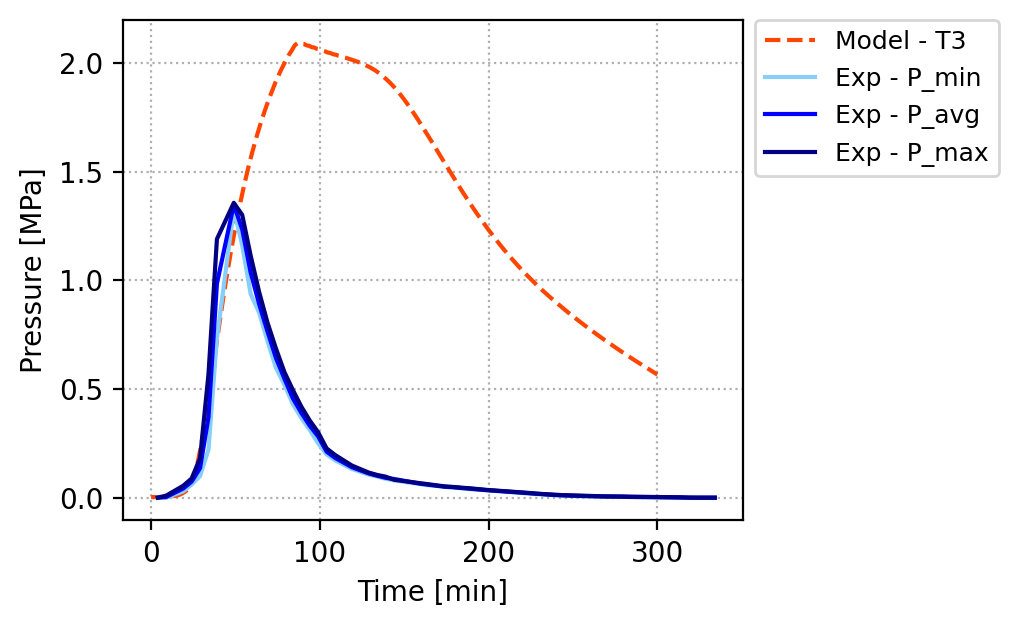

In [18]:
fig = plt.figure(figsize=(4, 3.25), dpi=200)
ts = np.linspace(0, 5 * 3600, 5 * 3600//5 + 1) / 60
plt.plot(ts, P_v_RAM_nodes[:, -40] * 1e-6, c='orangered', ls='--', marker='', markevery=50, label='Model - T3')
plt.plot(df['t_1'], df['Pmin_40mm'] / 10, c='lightskyblue', label='Exp - P_min')
plt.plot(df['t_1'], df['Pavg_40mm'] / 10, c='blue', label='Exp - P_avg')
plt.plot(df['t_1'], df['Pmax_40mm'] / 10, c='navy', label='Exp - P_max')

plt.ylabel('Pressure [MPa]')
plt.xlabel('Time [min]')

plt.grid(ls=':')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.025), fontsize=9)
# plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.25), fontsize=9)

plt.show()

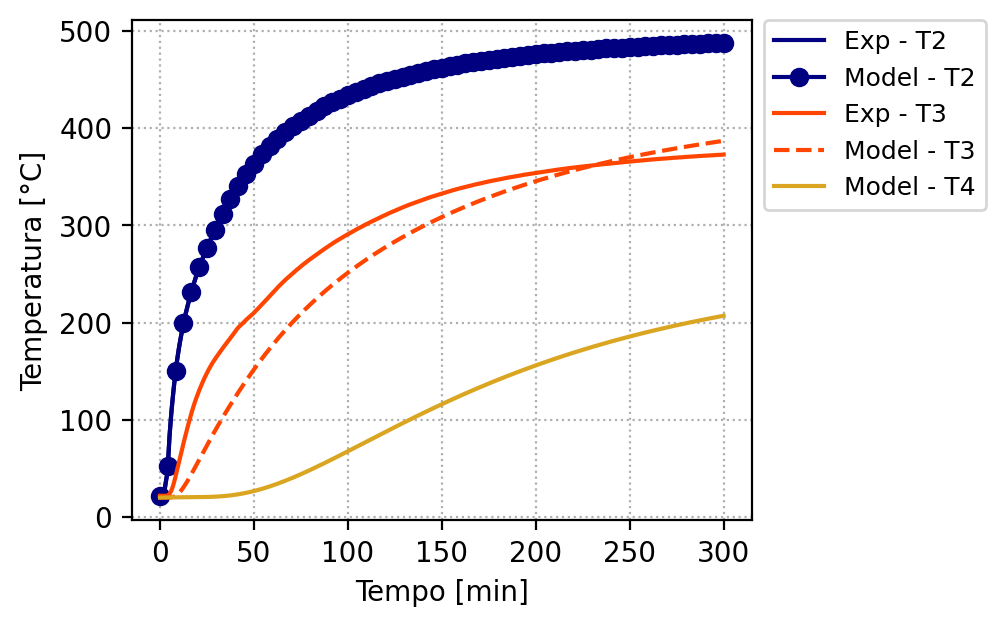

In [118]:
fig = plt.figure(figsize=(4, 3.25), dpi=200)
ts = np.linspace(0, 5 * 3600, 5 * 3600//5 + 1) / 60

plt.plot(df['t_2'], df['T_2'], c='navy', label='Exp - T2')
plt.plot(ts, T_RAM_nodes[:, -1], c='navy', marker='o', markevery=50, label='Model - T2')
plt.plot(df['t_2'], df['T_3'], c='orangered', label='Exp - T3')
plt.plot(ts, T_RAM_nodes[:, -40], c='orangered', ls='--', marker='', markevery=50, label='Model - T3')

plt.plot(ts, T_RAM_nodes[:, 0], c='goldenrod', label='Model - T4')

plt.ylabel('Temperatura [°C]')
plt.xlabel('Tempo [min]')

plt.grid(ls=':')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.025), fontsize=9)
# plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.25), fontsize=9)

plt.show()

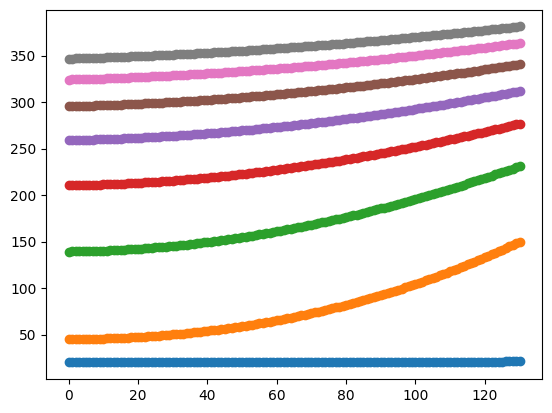

In [74]:
T_RAM_nodes.shape

for i in [0,100,200,300,400,500,600,700]:
    plt.plot(T_RAM_nodes[i], '-o')



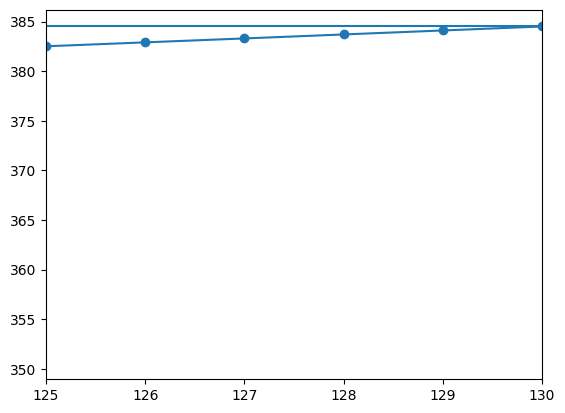

In [69]:
T_RAM_nodes.shape

# for i in [0,100,200,300,400,500,600,700]:
plt.plot(T_RAM_nodes[-1], '-o')
plt.xlim(125, 130)

plt.axhline(384.5)

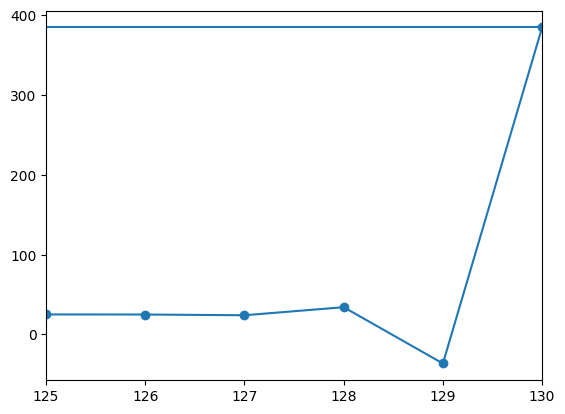

In [61]:
T_RAM_nodes.shape

# for i in [0,100,200,300,400,500,600,700]:
plt.plot(T_RAM_nodes[-1], '-o')
plt.xlim(125, 130)

plt.axhline(384.5)

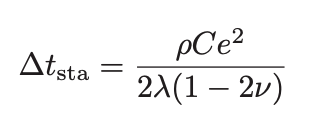

\begin{equation}
\Delta t \leq \Delta t_\text{sta} = \frac{\rho C_p h^2}{2 \lambda (1 - 2 \nu)} \tag{1}
\end{equation}

Para o nosso caso (solver explícito), $\nu = 0$, logo:

\begin{equation}
\Delta t \leq \Delta t_\text{sta} = \frac{\rho C_p h^2}{2 \lambda} \tag{2}
\end{equation}

In [62]:
(rho(25) * (1e-3)**3 * Cp(25) * (1)**2)/ (2 * lmbda(25) * (1e3))

3.15e-08

In [65]:
(rho(25) * Cp(25) * 0.001**2)/ (2 * lmbda(25))

0.0315